## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


## Importar dataset

In [2]:
df = pd.read_csv('data/ts_beer.csv')

In [3]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [4]:
df.tail()

,Month,Monthly beer production
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0
475,1995-08,153.0


In [5]:
df.shape

(476, 2)

In [6]:
df.columns.to_list()

['Month', 'Monthly beer production']

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly beer production,476.0,136.395378,33.738725,64.8,112.9,139.15,158.825,217.8


In [46]:
df['Month'] = pd.to_datetime(df['Month'], format="%Y-%m")

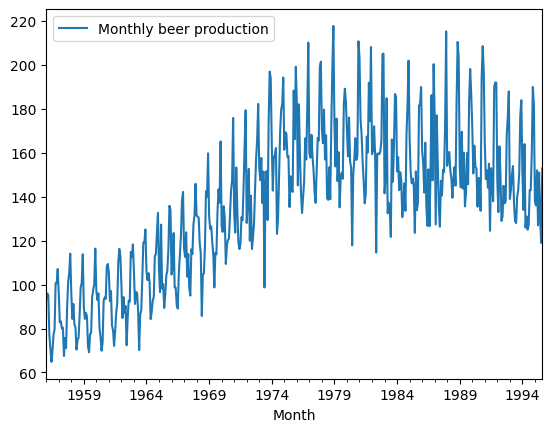

In [47]:
df.set_index('Month').plot();

In [50]:
def fit_straight_line(y, deg = 1):
    '''
    Fits a straight line between 2 data points.
    '''
    x_values = np.linspace(0, 1, len(y))

    coeffs = np.polyfit(x = x_values, y = y, deg = deg)
    poly_eqn = np.poly1d(coeffs)

    y_hat = poly_eqn(x_values)
    
    return y_hat

def plot_single_ts(df, origin, target_column, fit_line):
    '''
    Plots a Time Series data based on the origin you pass.
    '''
    x = df["Month"]
    y = df[target_column]
    
    if fit_line:
        y_hat = fit_straight_line(y = y)
        plt.plot(x, y_hat, color = "orange", label = "Trend")
    
    plt.plot(x, y, label = origin, lw = 4)
    plt.legend(loc = "upper left") 
    
def plot_time_series(df, target_column, fit_line):
    '''
    Plots all the available time series.
    '''
    fig = plt.figure(figsize = (15, 6))

    
    plot_single_ts(df = df, origin = "Beer", target_column = target_column, fit_line = fit_line)
    
    fig.tight_layout()
      

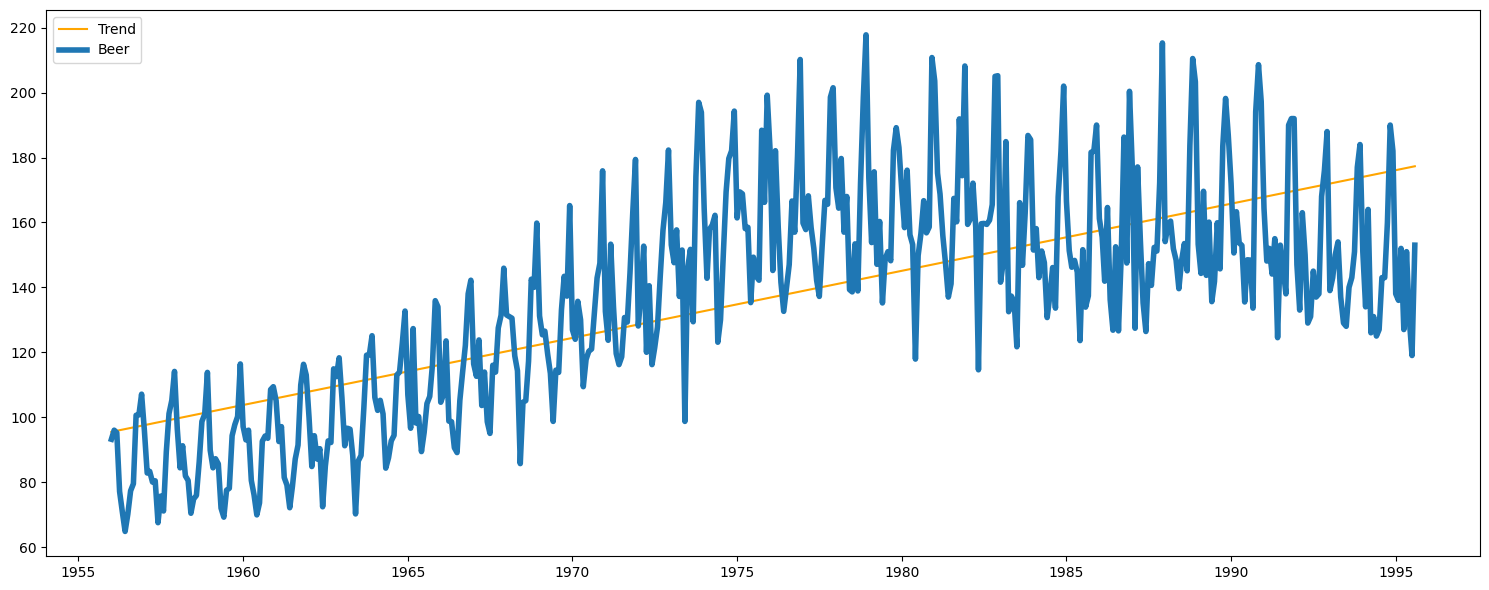

In [51]:
plot_time_series(df, 'Monthly beer production', fit_line=True)

- Univariante 
- Tendencia creciente
- Diferente varianza a lo largo del tiempo
- Se observan ciclos

## AR(p = 3)

In [55]:
df["lag_1"] = df['Monthly beer production'].shift(1)
df["lag_2"] = df['Monthly beer production'].shift(2)
df["lag_3"] = df['Monthly beer production'].shift(3)
df

,Month,Monthly beer production,lag_1,lag_2,lag_3
0,1956-01-01,93.2,NaN,NaN,NaN
1,1956-02-01,96.0,93.2,NaN,NaN
2,1956-03-01,95.2,96.0,93.2,NaN
3,1956-04-01,77.1,95.2,96.0,93.2
4,1956-05-01,70.9,77.1,95.2,96.0
...,...,...,...,...,...
471,1995-04-01,127.0,152.0,136.0,138.0
472,1995-05-01,151.0,127.0,152.0,136.0
473,1995-06-01,130.0,151.0,127.0,152.0
474,1995-07-01,119.0,130.0,151.0,127.0


## MA(q)

In [56]:
df['mean'] = df['Monthly beer production'].mean()

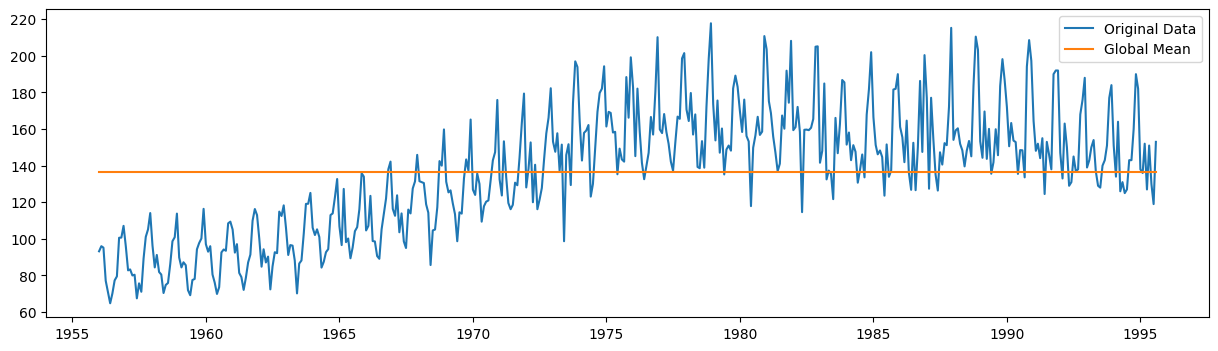

In [57]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()

x = df['Month']
y = df['Monthly beer production']
y_mean = df['mean']

ax.plot(x, y, label='Original Data')
ax.plot(x, y_mean, label='Global Mean')

plt.legend();

In [58]:
df['error'] = df['Monthly beer production'] - df['mean']

In [60]:
df['error_1'] = df['error'].shift(1)
df['error_2'] = df['error'].shift(2)
df['error_3'] = df['error'].shift(3)

In [61]:
df.tail()

,Month,Monthly beer production,lag_1,lag_2,lag_3,mean,error,error_1,error_2,error_3
471,1995-04-01,127.0,152.0,136.0,138.0,136.395378,-9.395378,15.604622,-0.395378,1.604622
472,1995-05-01,151.0,127.0,152.0,136.0,136.395378,14.604622,-9.395378,15.604622,-0.395378
473,1995-06-01,130.0,151.0,127.0,152.0,136.395378,-6.395378,14.604622,-9.395378,15.604622
474,1995-07-01,119.0,130.0,151.0,127.0,136.395378,-17.395378,-6.395378,14.604622,-9.395378
475,1995-08-01,153.0,119.0,130.0,151.0,136.395378,16.604622,-17.395378,-6.395378,14.604622


In [65]:
# Media movil MA(q=6)
df['ma_6'] = df['Monthly beer production'].shift(1).rolling(window=6).mean()
df.head(10)

,Month,Monthly beer production,lag_1,lag_2,lag_3,mean,error,error_1,error_2,error_3,ma_6
0,1956-01-01,93.2,NaN,NaN,NaN,136.395378,-43.195378,NaN,NaN,NaN,NaN
1,1956-02-01,96.0,93.2,NaN,NaN,136.395378,-40.395378,-43.195378,NaN,NaN,NaN
2,1956-03-01,95.2,96.0,93.2,NaN,136.395378,-41.195378,-40.395378,-43.195378,NaN,NaN
3,1956-04-01,77.1,95.2,96.0,93.2,136.395378,-59.295378,-41.195378,-40.395378,-43.195378,NaN
4,1956-05-01,70.9,77.1,95.2,96.0,136.395378,-65.495378,-59.295378,-41.195378,-40.395378,NaN
5,1956-06-01,64.8,70.9,77.1,95.2,136.395378,-71.595378,-65.495378,-59.295378,-41.195378,NaN
6,1956-07-01,70.1,64.8,70.9,77.1,136.395378,-66.295378,-71.595378,-65.495378,-59.295378,82.866667
7,1956-08-01,77.3,70.1,64.8,70.9,136.395378,-59.095378,-66.295378,-71.595378,-65.495378,79.016667
8,1956-09-01,79.5,77.3,70.1,64.8,136.395378,-56.895378,-59.095378,-66.295378,-71.595378,75.900000
9,1956-10-01,100.6,79.5,77.3,70.1,136.395378,-35.795378,-56.895378,-59.095378,-66.295378,73.283333


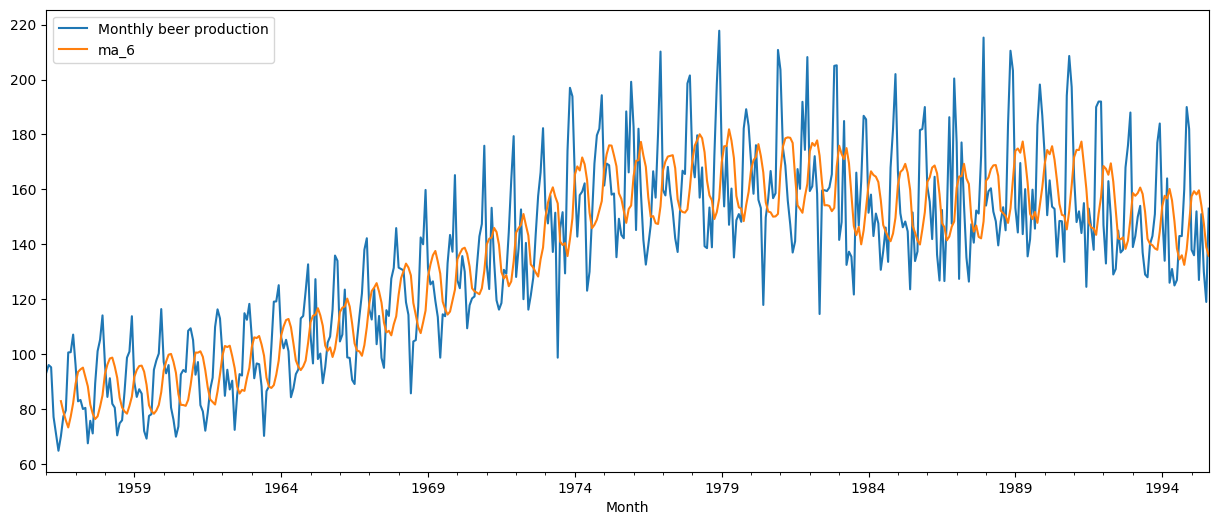

In [66]:
df.set_index('Month')[['Monthly beer production', 'ma_6']].plot(figsize=(15,6));

## Transformaciones STU

- Logaritmo
- Diferenciación

In [ ]:
df = df[['Month', 'Monthly beer production']]
df.columns = ['ds', 'y']

In [72]:
df

,ds,y
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9
...,...,...
471,1995-04-01,127.0
472,1995-05-01,151.0
473,1995-06-01,130.0
474,1995-07-01,119.0


In [73]:
df['y_log'] = df['y'].apply(np.log1p)

In [74]:
df['y_log_diff'] = df['y_log'].diff()

Text(0.5, 0.98, 'Plots for Beer Production Data and their transformation')

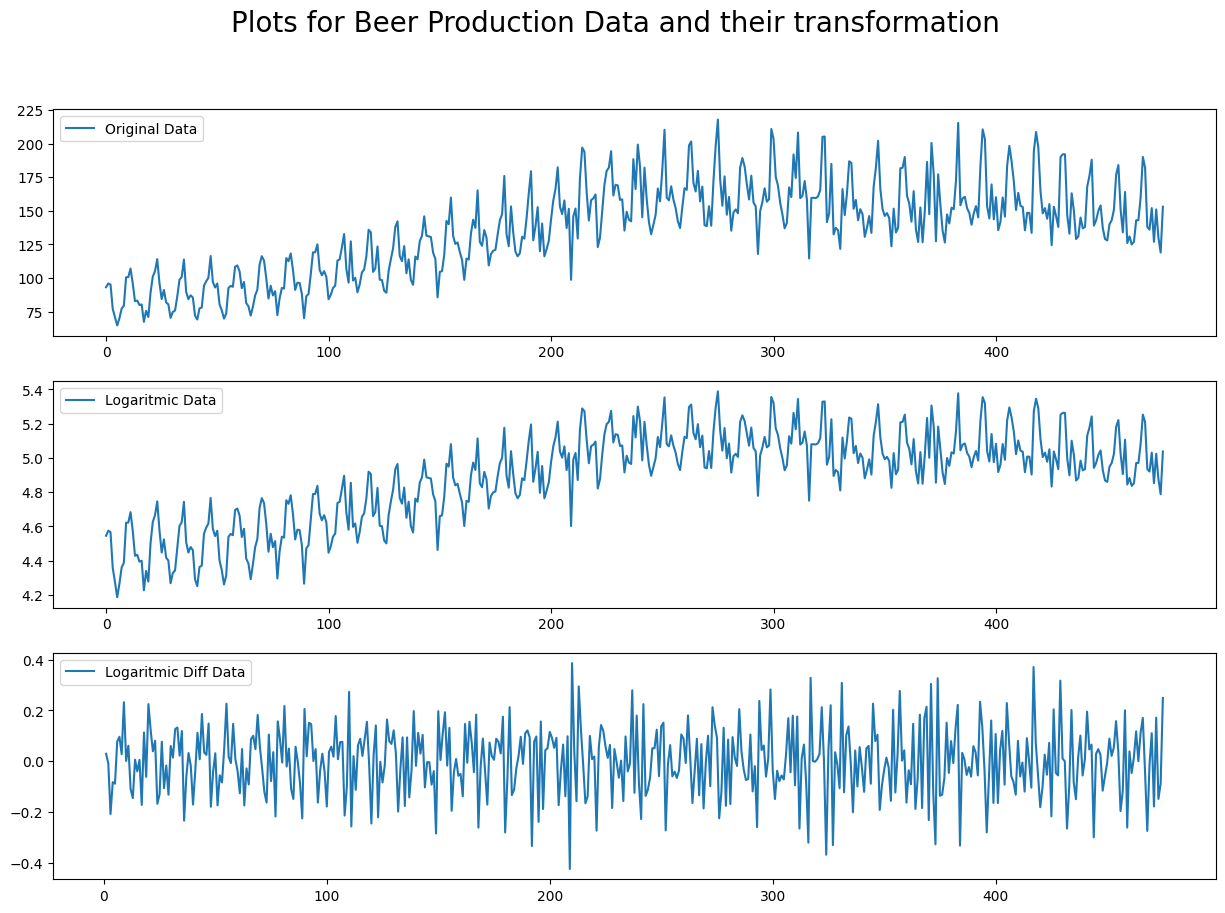

In [76]:
fig = plt.figure(figsize=(15,10))
ax1, ax2, ax3 = fig.subplots(3, 1)

ax1.plot(df['y'], label='Original Data')
ax2.plot(df['y_log'], label='Logaritmic Data')
ax3.plot(df['y_log_diff'], label='Logaritmic Diff Data')

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper left")
ax3.legend(loc = "upper left")

fig.suptitle('Plots for Beer Production Data and their transformation', fontsize=20)


In [77]:
transformaciones = ['y', 'y_log', 'y_log_diff']

In [84]:
for trans in transformaciones:
    
    serie = df[trans]
    
    print("------------------------------------------------------------------")
    
    print("Estamos trabajando con la transformación {}\n".format(trans))
    resultado_analisis = adfuller(serie.dropna())
    valor_estadistico_adf = round(resultado_analisis[0], 3)
    p_valor = round(resultado_analisis[1], 3)
    
    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))
    
    

------------------------------------------------------------------
Estamos trabajando con la transformación y

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -2.283

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.178

------------------------------------------------------------------
Estamos trabajando con la transformación y_log

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -2.796

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.059

------------------------------------------------------------------
Estamos trabajando con la transformación y_log_diff

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -4.87

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.0



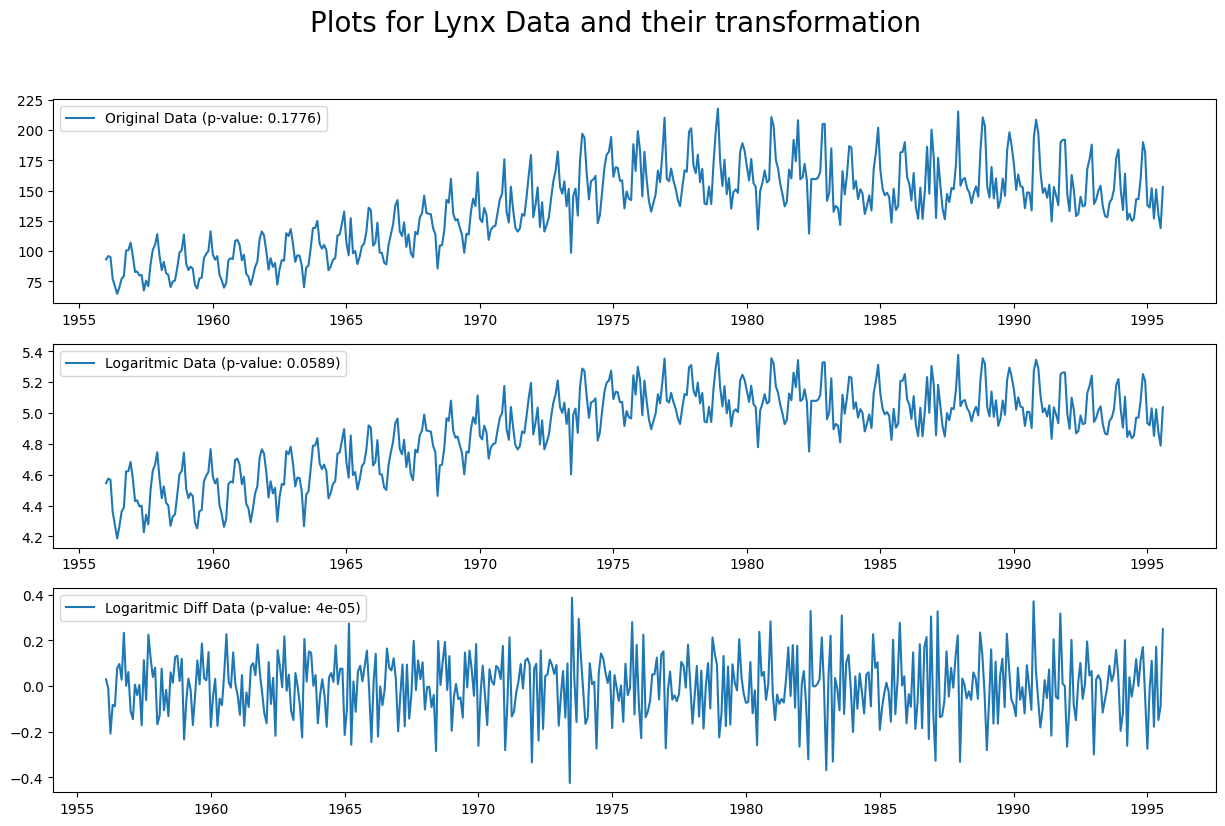

In [86]:
# instanciate the figure
fig = plt.figure(figsize = (15, 9))
ax1, ax2, ax3 = fig.subplots(3, 1)

# select x and y to plot
xbeer = df["ds"]

ybeer = df["y"]
y_logbeer = df["y_log"]
y_log_diffbeer = df["y_log_diff"]

# plotting part
ax1.plot(xbeer, ybeer, label = f"Original Data (p-value: {round(adfuller(ybeer)[1], 4)})")
ax2.plot(xbeer, y_logbeer, label = f"Logaritmic Data (p-value: {round(adfuller(y_logbeer)[1], 4)})")
ax3.plot(
    xbeer, 
    y_log_diffbeer, 
    label = f"Logaritmic Diff Data (p-value: {round(adfuller(y_log_diffbeer.dropna())[1], 5)})"
)

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper left")
ax3.legend(loc = "upper left")

fig.suptitle("Plots for Lynx Data and their transformation", fontsize = 20);

In [87]:
y_log_diffbeer.dropna(inplace=True)

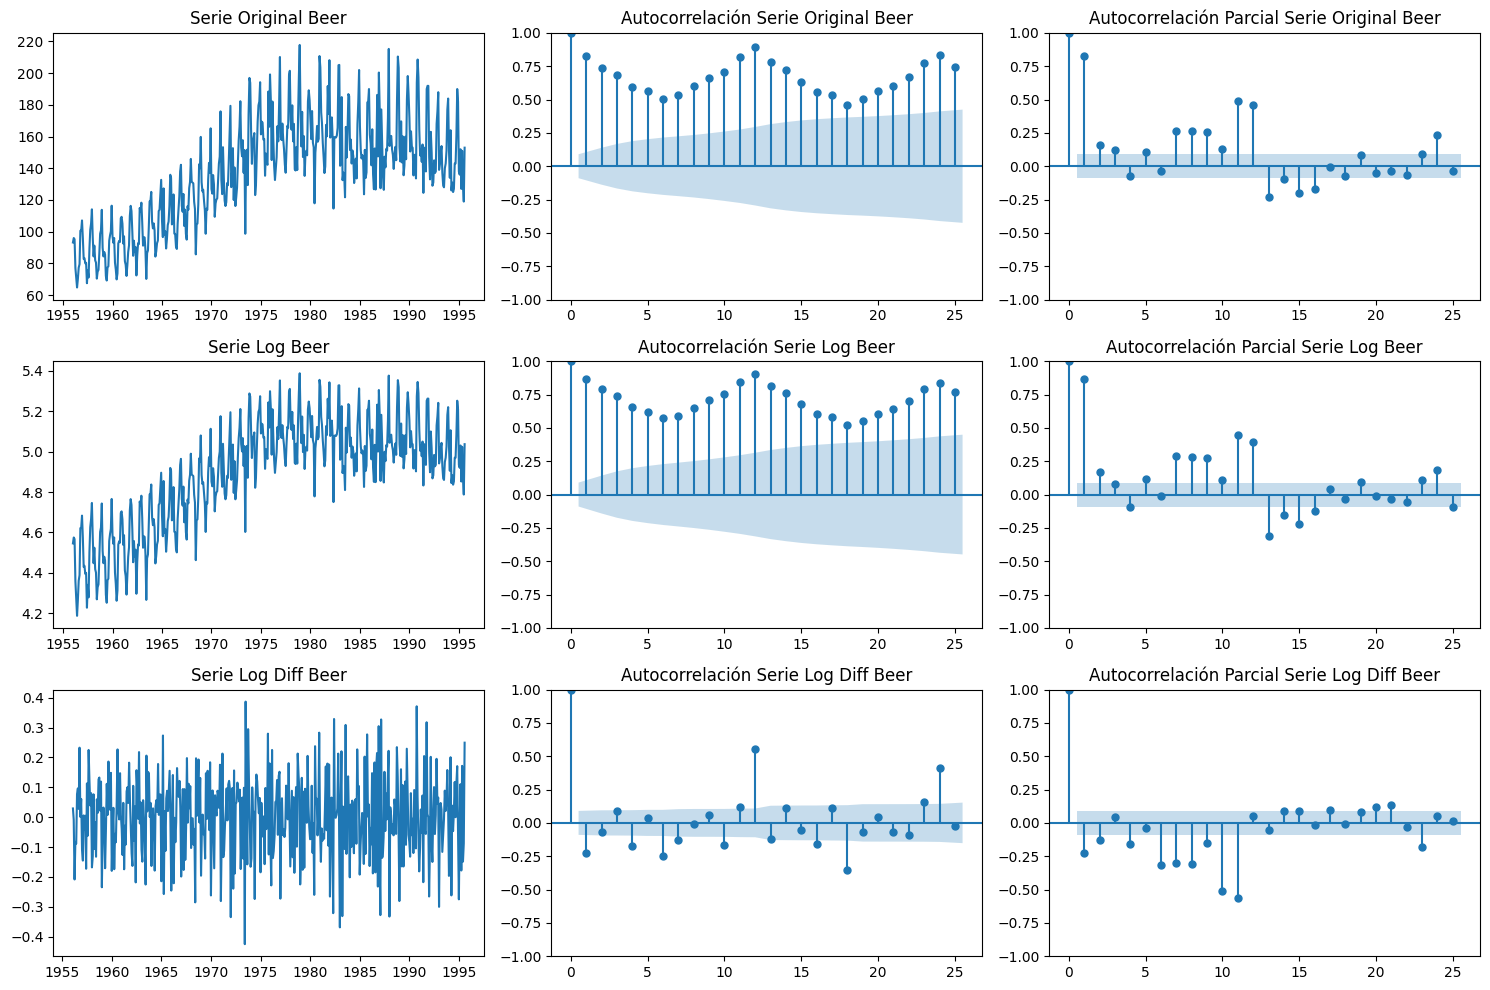

In [89]:
LAGS = 25

fig = plt.figure(figsize = (15, 10))

((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33)) = fig.subplots(3, 3)

ax11.plot(xbeer, ybeer)
ax11.set_title("Serie Original Beer")
plot_acf(ybeer, ax = ax12, lags = LAGS, title = "Autocorrelación Serie Original Beer")
plot_pacf(ybeer, ax = ax13, lags = LAGS, title = "Autocorrelación Parcial Serie Original Beer")

ax21.plot(xbeer, y_logbeer)
ax21.set_title("Serie Log Beer")
plot_acf(y_logbeer, ax = ax22, lags = LAGS, title = "Autocorrelación Serie Log Beer")
plot_pacf(y_logbeer, ax = ax23, lags = LAGS, title = "Autocorrelación Parcial Serie Log Beer")

ax31.plot(xbeer[1::], y_log_diffbeer)
ax31.set_title("Serie Log Diff Beer")
plot_acf(y_log_diffbeer, ax = ax32, lags = LAGS, title = "Autocorrelación Serie Log Diff Beer")
plot_pacf(y_log_diffbeer, ax = ax33, lags = LAGS, title = "Autocorrelación Parcial Serie Log Diff Beer")

fig.tight_layout()

In [98]:
# p -> (1 - 2)
# q -> (1- 12)
# d -> (0 - 1)

# A ojo -> ARIMA(p=2, d=1, q=12)

In [97]:
acf(x=y_log_diffbeer)[12]

0.5519283134173746

In [99]:
ts_to_predict_arima = df.set_index('ds')['y_log']

In [101]:
y_train_arima = ts_to_predict_arima[:-40]
y_test_arima = ts_to_predict_arima[-40:]

In [163]:
param = (12, 2, 12)
model = sm.tsa.statespace.SARIMAX(
    endog = y_train_arima,
    order= param,
    seasonal_order= (0, 0, 0, 0),
    enforce_invertibility= False,
    enforce_stationarity=False
)

model_fitted = model.fit()

print(f"ARIMA {param} x {(0,0,0,0)} 12 - AIC: {model_fitted.aic}")

/home/pbyte/Documentos/DataScienceWorkspace/otrosProyectos/Electric_Power_Consumption/dsVenv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/pbyte/Documentos/DataScienceWorkspace/otrosProyectos/Electric_Power_Consumption/dsVenv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09851D+00    |proj g|=  1.98421D+00

At iterate    5    f= -1.14054D+00    |proj g|=  1.57368D-01

At iterate   10    f= -1.18876D+00    |proj g|=  7.14946D-01

At iterate   15    f= -1.19968D+00    |proj g|=  1.56390D-01

At iterate   20    f= -1.20529D+00    |proj g|=  2.78946D-01

At iterate   25    f= -1.20982D+00    |proj g|=  5.21670D-02

At iterate   30    f= -1.21191D+00    |proj g|=  2.37051D-01

At iterate   35    f= -1.21331D+00    |proj g|=  1.07183D-01

At iterate   40    f= -1.21431D+00    |proj g|=  1.54845D-01

At iterate   45    f= -1.21565D+00    |proj g|=  1.72230D-01

At iterate   50    f= -1.21758D+00    |proj g|=  8.29672D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/pbyte/Documentos/DataScienceWorkspace/otrosProyectos/Electric_Power_Consumption/dsVenv/lib64/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [164]:
print(model_fitted.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3975      0.937     -1.492      0.136      -3.233       0.438
ar.L2         -1.2819      0.543     -2.362      0.018      -2.346      -0.218
ar.L3         -1.1038      0.770     -1.434      0.151      -2.612       0.405
ar.L4         -1.2532      0.438     -2.859      0.004      -2.112      -0.394
ar.L5         -1.1222      0.831     -1.351      0.177      -2.751       0.506
ar.L6         -1.3046      0.362     -3.602      0.000      -2.015      -0.595
ar.L7         -1.3459      0.916     -1.470      0.142      -3.140       0.448
ar.L8         -1.2572      0.519     -2.423      0.015      -2.274      -0.240
ar.L9         -1.0936      0.774     -1.412      0.158      -2.611       0.424
ar.L10        -1.1919      0.428     -2.785      0.005      -2.031      -0.353
ar.L11        -1.0489      0.784     -1.338      0.1

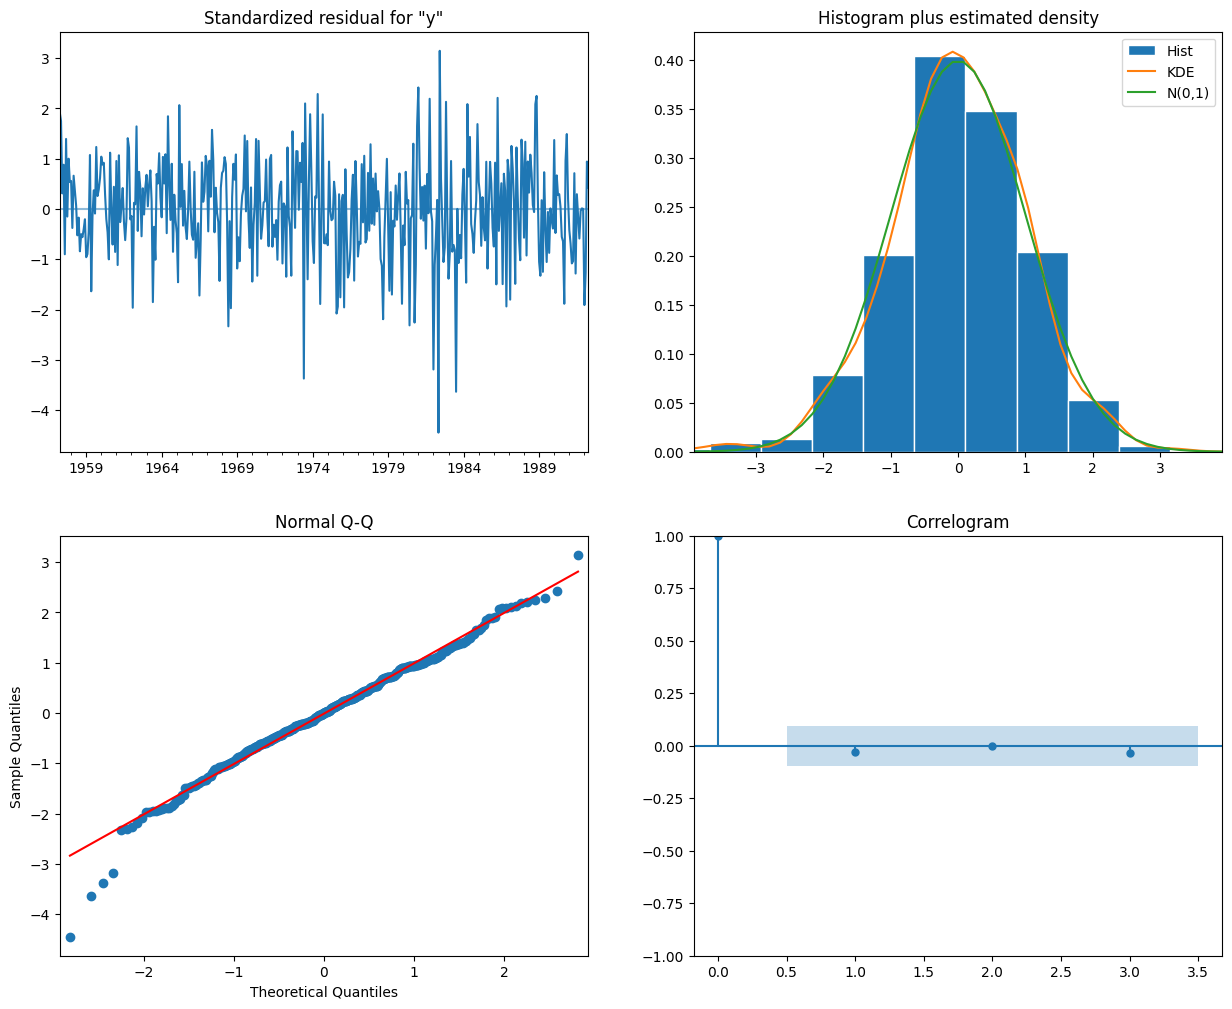

In [165]:
model_fitted.plot_diagnostics(figsize=(15,12), lags=3);

In [170]:
pred_uc = model_fitted.get_forecast(steps = 100)
y_pred_arima = pred_uc.predicted_mean

In [125]:
y_pred_arima

1992-05-01    5.033381
1992-06-01    5.057701
1992-07-01    5.055050
1992-08-01    5.064954
1992-09-01    5.061677
1992-10-01    5.066213
1992-11-01    5.063923
1992-12-01    5.066180
1993-01-01    5.064789
1993-02-01    5.065970
1993-03-01    5.065168
1993-04-01    5.065803
1993-05-01    5.065351
1993-06-01    5.065697
1993-07-01    5.065445
1993-08-01    5.065635
1993-09-01    5.065496
1993-10-01    5.065600
1993-11-01    5.065523
1993-12-01    5.065580
1994-01-01    5.065538
1994-02-01    5.065570
1994-03-01    5.065546
1994-04-01    5.065563
1994-05-01    5.065550
1994-06-01    5.065560
1994-07-01    5.065553
1994-08-01    5.065558
1994-09-01    5.065554
1994-10-01    5.065557
1994-11-01    5.065555
1994-12-01    5.065557
1995-01-01    5.065555
1995-02-01    5.065556
1995-03-01    5.065556
1995-04-01    5.065556
1995-05-01    5.065556
1995-06-01    5.065556
1995-07-01    5.065556
1995-08-01    5.065556
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 0.98, 'Beer Values and ARIMA Forecast')

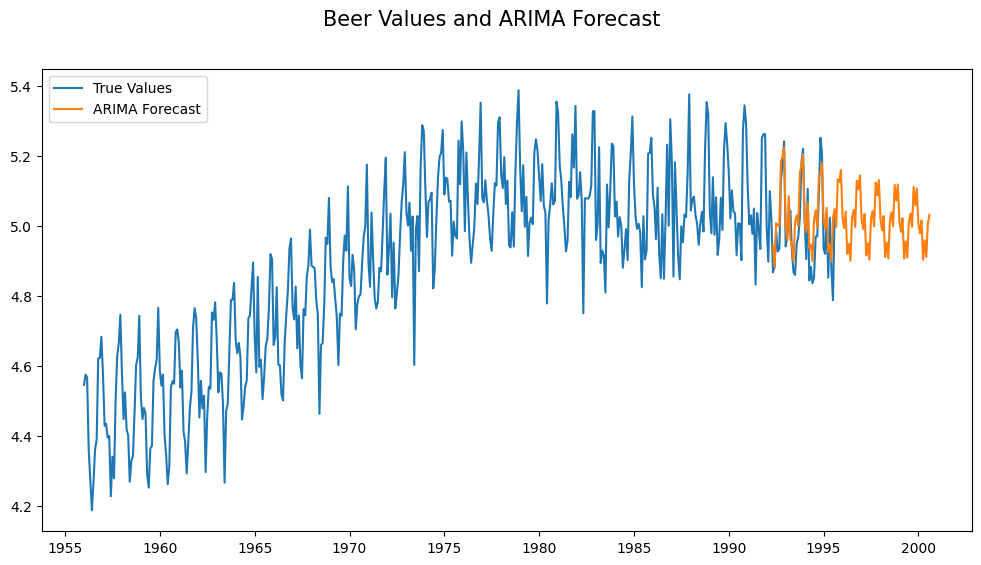

In [171]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_to_predict_arima, label = "True Values")
ax.plot(y_pred_arima, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("Beer Values and ARIMA Forecast", fontsize = 15)

## Prophet

In [129]:
df_prophet = df[['ds', 'y']]

In [133]:
# el único requisito del algoritmo prophet es que el input sea un df y que tenga 2 columnas: 
# ds la columna de tiempo
# y la columna con la cantidad

# instaciamos el modelo
prophet = Prophet()

# entrenamos nuestro modelo
prophet.fit(df_prophet)

# preparamos un df para la predicción futura
# prophet nos da la función auxiliar de make_future_dataframe
# que permite generar automáticamente los periodos necesarios para el forecast futuro
future_df = prophet.make_future_dataframe(periods = 100, freq = "M", include_history = True)

# hacemos la predicción
y_pred_prophet = prophet.predict(future_df)

14:04:33 - cmdstanpy - INFO - Chain [1] start processing


14:04:33 - cmdstanpy - INFO - Chain [1] done processing


/home/pbyte/Documentos/DataScienceWorkspace/otrosProyectos/Electric_Power_Consumption/dsVenv/lib64/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/pbyte/Documentos/DataScienceWorkspace/otrosProyectos/Electric_Power_Consumption/dsVenv/lib64/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


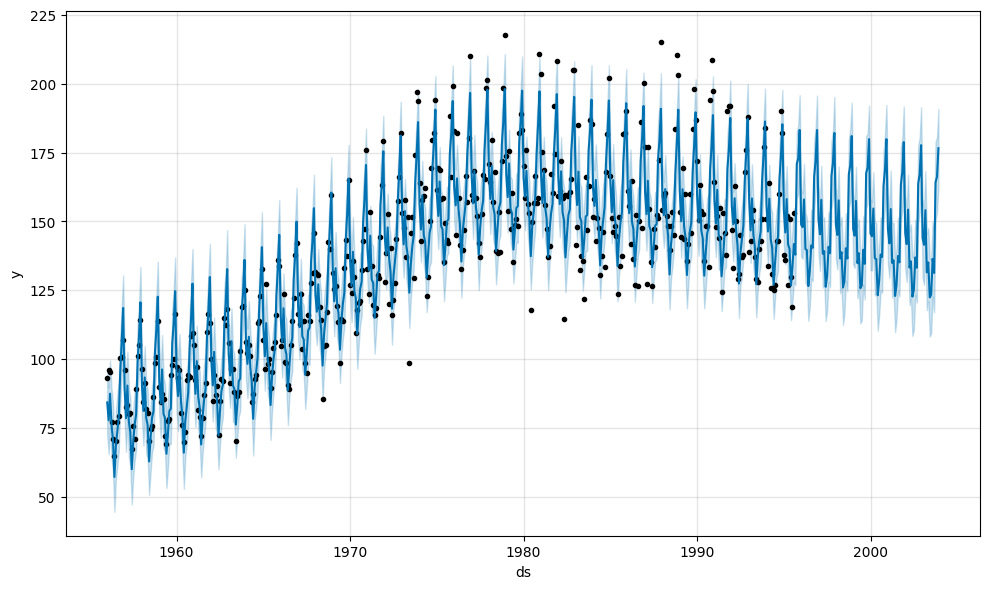

In [134]:
prophet.plot(y_pred_prophet);

## Holt Winters

In [180]:
ts_prophet = pd.read_excel('data/ts_prophet.xlsx', index_col=0)

In [181]:
ts_prophet['yhat'] = ts_prophet['yhat']/1_000_000

In [182]:
ts_prophet.columns = ['ds', 'y', 'origin']

In [183]:
ts_prophet

,ds,y,origin
1152,2017-03-31,125.417282,Sector_1
1153,2017-04-30,143.938011,Sector_1
1154,2017-05-31,151.784133,Sector_1
1155,2017-06-30,162.509513,Sector_1
1156,2017-07-31,168.997715,Sector_1
...,...,...,...
3119,2021-02-28,19.801367,Sector_5
3120,2021-03-31,19.289049,Sector_5
3121,2021-04-30,19.497033,Sector_5
3122,2021-05-31,21.110790,Sector_5


In [185]:
ts_sector_1_list = ts_prophet[ts_prophet['origin'] == 'Sector_1']['y'].tolist()

In [186]:
print(str(ts_sector_1_list[:2]), "..." + str(ts_sector_1_list[-2:]))

[125.4172818923455, 143.9380108899385] ...[395.0426052412139, 402.5360888282046]


In [187]:
def naive_forecast(series):
    '''
    Implements the naive forecasting method.
    '''
    return series[-1]

In [188]:
naive_forecast(series = ts_sector_1_list)

402.5360888282046

In [189]:
def average_forecast(series):
    '''
    Implements the average forecasting method.
    '''
    return np.mean(series)

In [190]:
average_forecast(series = ts_sector_1_list)

272.8557012631103

In [191]:
def moving_average_forecast(series, window):
    '''
    Implements the moving average forecasting method.
    '''
    return np.mean(series[-window:])

In [192]:
moving_average_forecast(series = ts_sector_1_list, window = 3)

396.0382678639001

In [193]:
def weighted_moving_average_forecast(series, weights):
    '''
    Implements the weighted moving average forecasting method.
    '''
    assert np.sum(np.array(weights)) == 1, f"Weights must add to 1. The actual sum is {round(np.sum(weights), 2)}"
    
    return sum(np.array(series[-len(weights):]) * np.array(weights))

In [195]:
# la suma de los pesos debe dar igual a 1, en caso contrario podemos tener resultados raros
weights = [0.1, 0.2, 0.3, 0.4]
weighted_moving_average_forecast(series = ts_sector_1_list, weights = weights)

395.15916671904336